# Import dates and date coverage for OpenSAFELY-TPP data sources

This [OpenSAFELY](https://www.opensafely.org/) notebook provides data import dates and counts of raw event data for externally linked data sources in the [OpenSAFELY-TPP database](https://docs.opensafely.org/dataset-systmone/). It is part of the technical documentation for users of the OpenSAFELY platform to guide analyses and **it should not be used for inference about any aspect of the pandemic, public health, or health service activity**. For the avoidance of doubt: any clinical or epidemiological interpretation of this raw information is likely to be a misinterpretation. 

If you would like to apply to use the OpenSAFELY platform please read our [documentation](https://docs.opensafely.org/), the [principles of the platform](https://www.opensafely.org/about/), and information about our [pilot programme for onboarding external users](https://www.opensafely.org/onboarding-new-users/).

If you want to see the Python code used to create this notebook, you can [view it on GitHub](https://github.com/opensafely/database-notebooks/blob/master/notebooks/database-builds.ipynb).


### Data sources
The core SystmOne primary care datasets are held in the `S1` tables in the OpenSAFELY-TPP database. 
The delay from events being recorded in SystmOne to being available in OpenSAFELY-TPP is around 2 - 9 days.
Reducing this to one day is possible for urgent queries where necessary.

All externally-linked data sources are listed below, with the table name given in brackets:

* All positive or negative SARS-CoV2 tests, from SGSS (`SGSS_AllTests_Positive` and `SGSS_AllTests_Negative`)
* First-ever positive or negative SARS-CoV2 test, from SGSS (`SGSS_Positive` and `SGSS_Negative`)
* A&E attendances, from SUS Emergency Care data (`EC`)
* In-patient hospital admissions, from SUS Admitted Patient Care Spells data (`APCS`)
* Out-patient hospital appointments, from SUS (`OPA`)
* Covid-related ICU admissions, from ICNARC (`ICNARC`)
* Covid-related in-hospital deaths, from CPNS (`CPNS`)
* COVID-19 Infection Survey, from ONS (`ONS_CIS`)
* All-cause registered deaths, from ONS (`ONS_Deaths`)
* High cost drugs (`HighCostDrugs`)
* Unique Property Reference Number, used for deriving household variables (`UPRN`)
* Master Patient Index (`MPI`)
* Health and Social Care Worker identification, collected at the point of vaccination (`HealthCareWorker`)

Some of these tables are accompanied by additional tables with further data. For instance, `OPA` contains the core out-patient appointment event data, and is supplemented by the `OPA_Cost`, `OPA_Diag`, `OPA_Proc` tables. See the [data schema notebook](https://github.com/opensafely/database-notebooks/blob/master/notebooks/database-schema.ipynb) for more information. 


In [1]:
## Import libraries

%load_ext autoreload
%autoreload 2

import pyodbc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.dates as mdates
from contextlib import contextmanager
from datetime import date, datetime
from IPython.display import display, Markdown

import sys
sys.path.append('../lib/')
from functions import *

In [2]:
# get server credentials from environment variable

dbconn = os.environ.get('FULL_DATABASE_URL', None).strip('"')

In [3]:
## Import libraries

with closing_connection(dbconn) as cnxn:
    DBbuild = pd.read_sql("""select * from LatestBuildTime""", cnxn)
    latestbuilds = pd.read_sql(
    """
        select BuildDesc as datasource, max(BuildDate) as latest_import from BuildInfo
        group by BuildDesc
    """, cnxn)
    allbuilds = pd.read_sql("""select * from BuildInfo""", cnxn)

# select start and end dates
start_date = pd.to_datetime("2020-02-01", format='%Y-%m-%d')
#start_date = pd.to_datetime("2020-02-01", format='%Y-%m-%d')
end_date = pd.to_datetime(latestbuilds['latest_import'].max(), format='%Y-%m-%d')
run_date = date.today()
run_datetime = datetime.now()

### Notebook run date

In [4]:
display(Markdown(f"""This notebook was run on {run_date.strftime('%-d %B %Y')}.  The information below reflects the state of the OpenSAFELY-TPP as at this date."""))

This notebook was run on 25 January 2022.  The information below reflects the state of the OpenSAFELY-TPP as at this date.

## Latest dataset import dates
TPP create a snapshot of the primary care information captured in the SystmOne database which is processed (for example unstructured free-text is removed and other OpensAFELY-specific tables are created) before being imported into the OpenSAFELY-TPP database. 
TPP also receive (or "ingest") external datasets from NHS Digital, ONS, etc., which are processed and imported into OpenSAFELY-TPP. 
Each imported dataset over-writes previously-imported data.

Once a dataset has been imported, it can be queried immediately in the secure environment. 
SystmOne data is imported approximately weekly. 
External datasets are usually imported within a few days after they have been received by TPP. 
Each external dataset is received at different times, sometimes irregularly or with unexpected delays.

The dates in the table below reflect when the datasets were last imported into the OpenSAFELY-TPP database.
They do not reflect when the data were received by TPP nor when the latest clinical or administrative events captured in each dataset occurred.

In [5]:
latestbuilds

,datasource,latest_import
0,APCS,2022-01-04 12:00:32.390
1,CPNS,2022-01-21 08:46:37.857
2,EC,2022-01-21 09:37:38.180
3,ECDS,2020-04-21 14:48:09.543
4,HealthCareWorker,2022-01-21 09:37:59.870
5,HighCostDrugs,2020-11-27 14:15:31.460
6,ICNARC,2021-01-21 11:21:12.623
7,MPI,2020-08-05 11:26:13.247
8,ONS_CIS,2021-04-28 14:59:47.487
9,ONS_Deaths,2022-01-17 09:51:23.847


## All dataset import dates
The figure below shows all dataset import dates for SystmOne and external datasets, up until the date this notebook was run (the vertical black line).

Text(0.5, 1.0, 'Latest dataset import dates as at 25 January 2022')

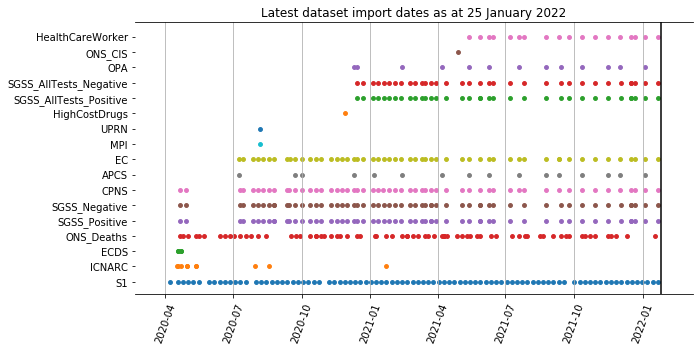

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

sources = allbuilds['BuildDesc'].unique()

for source in allbuilds['BuildDesc'].unique():
    dat = allbuilds[(allbuilds['BuildDesc']==source)]
    x = dat['BuildDate']
    y = dat['BuildDesc']
    ax.scatter(x, y, marker='.', s=60)

ax.xaxis.set_tick_params(labelrotation=70)
ax.grid(True, axis='x')
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.axvline(run_datetime, color='black')
ax.set_title(f"""Latest dataset import dates as at {run_date.strftime('%-d %B %Y')}""")

## Event activity in external datasets

In the figures below, event activity (counts of events such as hospital admissions and deaths) is reported for external data sources from 1 February 2020 up to the notebook run date (left plot), and for the latest 30 days of activity up to the most recent event date (right plot). 

The left plots can be used to gain a rough idea of event activity over time and helps to sense-check event frequencies and/or population counts in extracted datasets; it should not be used for direct clinical or epidemiological inference. The right plots can be used to gauge the latest reliable date for events recorded in each data source, i.e., a cut-off beyond which the data may be incomplete. 

Note that the OpenSAFELY-TPP database only includes people who were ever registered at a GP practice using TPP's SystmOne clinical information system (roughly 40% of GP practices) on or after 1 January 2009, including those who have since deregistered or died. The data therefore captures activity for these patients only.

Counts of five or less are redacted. 


In [7]:
# Make a dataframe with consecutive dates
date_range = pd.DataFrame(
    index = pd.date_range(start=start_date, end=end_date, freq="D")
)

In [8]:
def datequery(table, var_table, from_date, to_date):
    query = (
      f"""
        SELECT {var_table} AS date, COUNT(*) AS count
        FROM {table}
        WHERE {var_table} >= CONVERT(date, '{from_date}') AND {var_table} <= CONVERT(date, '{to_date}')
        GROUP BY {var_table}
        ORDER BY {var_table}
      """
    )
    return query

start_date_text = start_date.strftime('%Y-%m-%d')
end_date_text = end_date.strftime('%Y-%m-%d')

#CodedEvent_query = datequery("CodedEvent", "ConsultationDate", "consultation_date", start_date_text, end_date_text)
#Appointment_query = datequery("Appointment", "SeenDate", "appointment_date", start_date_text, end_date_text)
APCS_query = datequery("APCS", "Admission_Date", start_date_text, end_date_text)
CPNS_query = datequery("CPNS", "DateOfDeath", start_date_text, end_date_text)
EC_query = datequery("EC", "Arrival_Date", start_date_text, end_date_text)
ICNARC_query = datequery("ICNARC", "CONVERT(date, IcuAdmissionDateTime)", start_date_text, end_date_text)
ONS_query = datequery("ONS_Deaths", "dod", start_date_text, end_date_text)
OPA_query = datequery("OPA", "Appointment_Date", start_date_text, end_date_text)
SGSS_query = datequery("""( 
         SELECT Earliest_Specimen_Date FROM SGSS_Positive 
         UNION ALL
         SELECT Earliest_Specimen_Date FROM SGSS_Negative
         )  AS a""", 
        "Earliest_Specimen_Date", start_date_text, end_date_text)
SGSSpos_query = datequery("SGSS_Positive", "Earliest_Specimen_Date", start_date_text, end_date_text)
SGSS_AllTests_query = datequery("""( 
         SELECT Specimen_Date FROM SGSS_AllTests_Positive 
         UNION ALL
         SELECT Specimen_Date FROM SGSS_AllTests_Negative
         )  AS a""", 
        "Specimen_Date", start_date_text, end_date_text)
SGSSpos_AllTests_query = datequery("SGSS_AllTests_Positive", "Specimen_Date", start_date_text, end_date_text)

with closing_connection(dbconn) as cnxn:
    #CodedEvent_df = pd.read_sql(CodedEvent_query, cnxn, parse_dates=['coded_event_date'])
    #Appointment_df = pd.read_sql(Appointment_query, cnxn, parse_dates=['appointment_date'])
    APCS_df = pd.read_sql(APCS_query, cnxn, parse_dates=['date'])
with closing_connection(dbconn) as cnxn:
    OPA_df = pd.read_sql(OPA_query, cnxn, parse_dates=['date'])
with closing_connection(dbconn) as cnxn:
    CPNS_df = pd.read_sql(CPNS_query, cnxn, parse_dates=['date'])
with closing_connection(dbconn) as cnxn:
    EC_df = pd.read_sql(EC_query, cnxn, parse_dates=['date'])
with closing_connection(dbconn) as cnxn:
    ICNARC_df = pd.read_sql(ICNARC_query, cnxn, parse_dates=['date'])
with closing_connection(dbconn) as cnxn:
    ONS_df = pd.read_sql(ONS_query, cnxn, parse_dates=['date'])
with closing_connection(dbconn) as cnxn:
    SGSS_df = pd.read_sql(SGSS_query, cnxn, parse_dates=['date'])
with closing_connection(dbconn) as cnxn:
    SGSSpos_df = pd.read_sql(SGSSpos_query, cnxn, parse_dates=['date'])
with closing_connection(dbconn) as cnxn:
    SGSS_all_df = pd.read_sql(SGSS_AllTests_query, cnxn, parse_dates=['date'])
with closing_connection(dbconn) as cnxn:
    SGSSpos_all_df = pd.read_sql(SGSSpos_AllTests_query, cnxn, parse_dates=['date'])
    
# Note that CodedEvent and Appointment extracts take a long time to run.

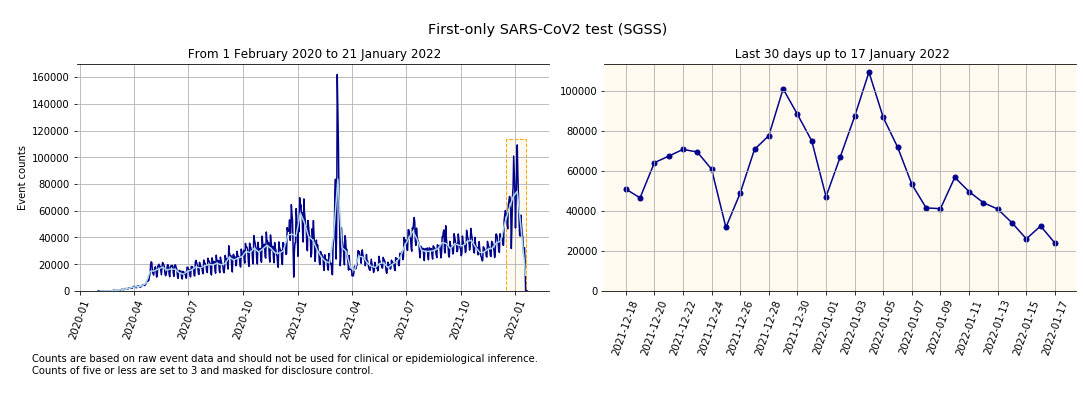

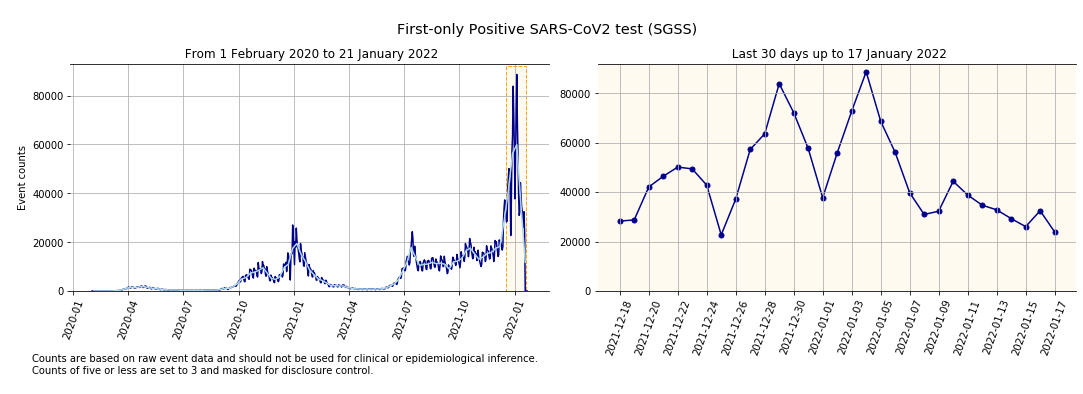

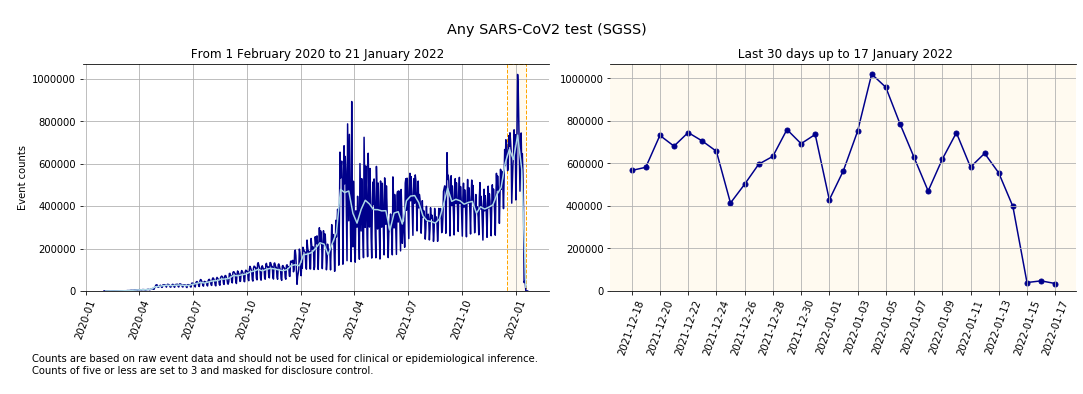

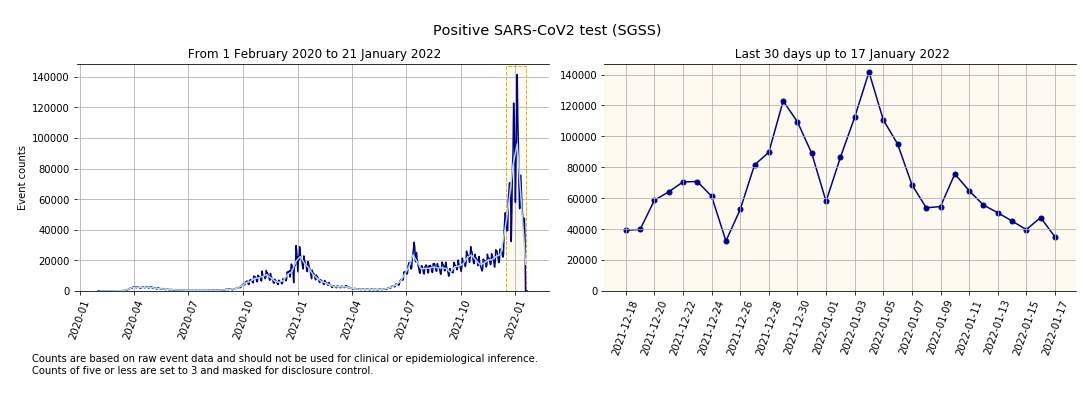

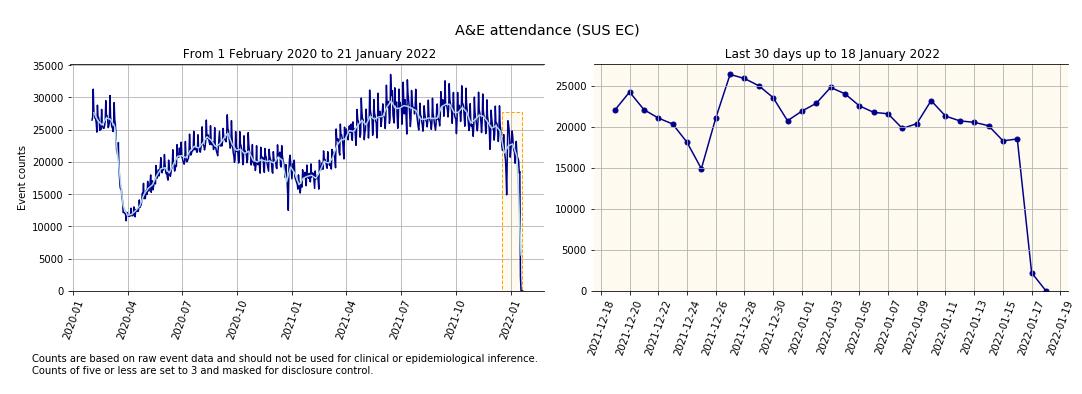

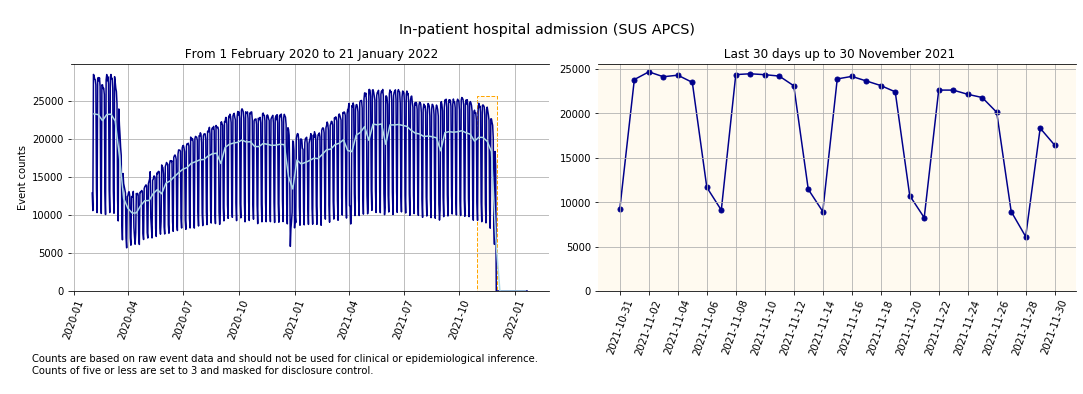

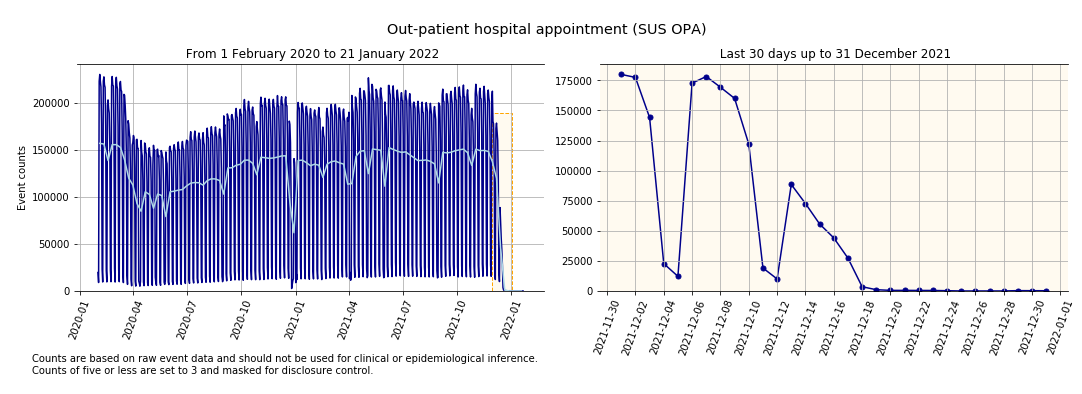

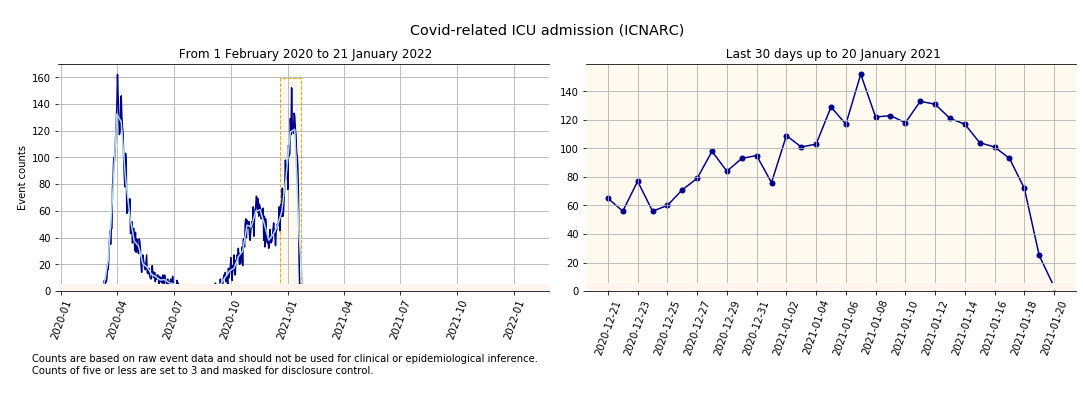

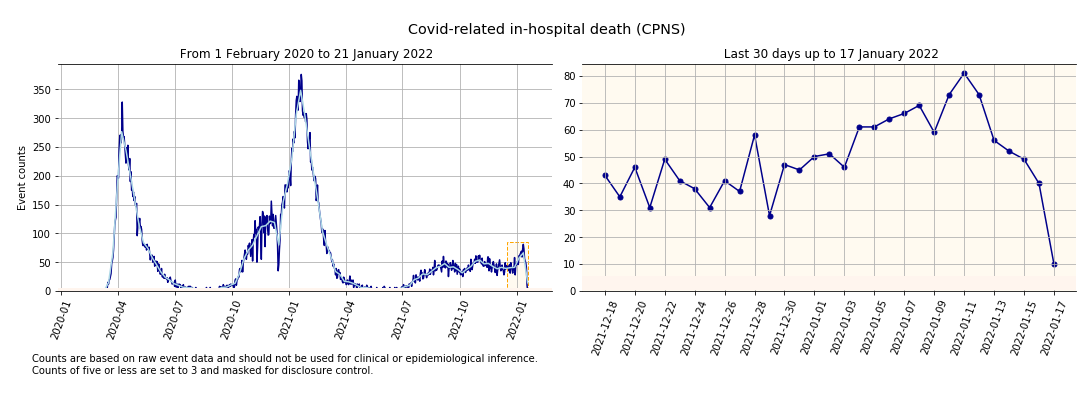

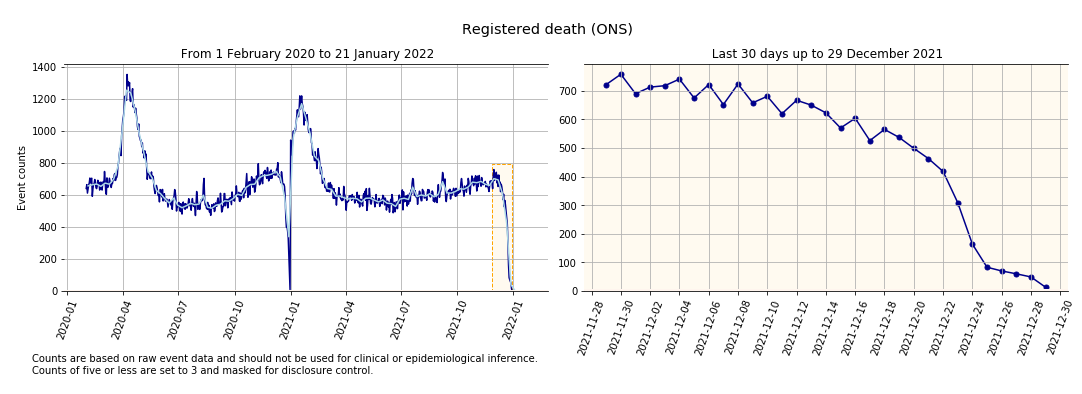

In [12]:
def eventcountseries(df, date_range, rule='D', popadjust=False):
    # to calculate the daily count for events recorded in a series
    # where event_dates is a series
    # set popadjust = 1000, say, to report counts per 1000 population
    
    df = df.set_index('date')
    counts = df['count'].reindex(date_range.index, fill_value=0)
            
    if rule != "D":
        counts = counts.resample(rule).sum()
    
    if popadjust is not False:
        pop = counts.sum()
        poppern= pop/popadjust
        counts = counts.transform(lambda x: x/poppern)
    
    return(counts)

def createcounts(date_range, df, lastdate, lookback):
    counts_day = eventcountseries(df, date_range, rule="D")
    counts_week = eventcountseries(df, date_range, rule="W-FRI")
       
    lastdaterecent = lastdate - pd.to_timedelta(lookback, unit="D")
    lastcounts = counts_day.loc[(counts_day.index >= lastdaterecent) & (counts_day.index <= lastdate)]
    lastredact = (lastcounts <6) & (lastcounts>0)
    lastcounts = lastcounts.where(~lastredact, 3) #redact small numbers
        
    redact_day = (counts_day <6) & (counts_day>0)
    counts_day = counts_day.where(~redact_day, 3)
        
    redact_week = (counts_week <6) & (counts_week>0)
    counts_week = counts_week.where(~redact_week, 3)
    
    return counts_day, counts_week, lastcounts, lastredact


def plotcounts(date_range, df, title=""):
    # This function plots event counts over time both overall and for the last X days up to the most recent extracted event.
    
    date = df['date']
    startdate = date_range.index.min()
    enddate = date_range.index.max()
    lastdate = df['date'].max()
        
    startdatestring = startdate.strftime('%-d %B %Y')
    enddatestring = enddate.strftime('%-d %B %Y')
    lastdatestring = lastdate.strftime('%-d %B %Y')
    
    lookback=30

    counts_day, counts_week, lastcounts, redact = createcounts(date_range, df, lastdate, lookback)
    
   # xlimlower = mdates.date2num(lastcounts.index[0]+pd.DateOffset(days=-1))
   # xlimupper = mdates.date2num(lastcounts.index[-1]+pd.DateOffset(days=+1))
    
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    
    axs[1].plot(lastcounts.index, lastcounts, marker='o', markersize=5, color='darkblue', zorder=1)
    axs[1].plot(lastcounts[redact].index, lastcounts[redact], 'o', linestyle = 'None', color='None', zorder=2)
    axs[1].xaxis.set_tick_params(labelrotation=70)
    axs[1].xaxis.set_major_locator(ticker.MultipleLocator(2))
    axs[1].set_ylim(bottom=0)
    xlimlower1, xlimupper1 = axs[1].get_xlim()
    ylimlower1, ylimupper1 = axs[1].get_ylim()
    axs[1].set_ylim(bottom=0, top=max([ylimupper1, 10]))
    axs[1].add_patch(patches.Rectangle((xlimlower1,0.5), xlimupper1-xlimlower1, 5, linewidth=1, edgecolor='none', facecolor='seashell', zorder=3))
    axs[1].grid(True)
    axs[1].spines["left"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].set_title(f"""\n\n Last {str(lookback)} days up to {lastdatestring}""")
    axs[1].set_facecolor('floralwhite')
    
    axs[0].plot(counts_day.index, counts_day, color='darkblue', zorder=2)
    axs[0].plot(counts_week.index - pd.DateOffset(3), counts_week/7, color='lightblue', zorder=3)
    axs[0].set_ylabel('Event counts')
    axs[0].xaxis.set_tick_params(labelrotation=70)
    axs[0].set_ylim(bottom=0)
    axs[0].grid(True)
    axs[0].spines["left"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].set_title(f"""\n\n From {startdatestring} to {enddatestring}""")
    xlimlower0, xlimupper0 = axs[0].get_xlim()
    ylimlower0, ylimupper0 = axs[0].get_ylim()
    axs[0].add_patch(patches.Rectangle((xlimlower1,0), xlimupper1-xlimlower1, max([ylimupper1, 10]), linewidth=1, edgecolor='orange', linestyle='--', facecolor='floralwhite', zorder=1))
    axs[0].add_patch(patches.Rectangle((xlimlower0,0) ,xlimupper0-xlimlower0, 5, linewidth=1, edgecolor='none', facecolor='seashell', zorder=5))
    
    plt.subplots_adjust(top=0.8, wspace = 0.2, hspace = 0.9)
    plt.tight_layout()
    fig.suptitle("\n"+title, y=1, fontsize='x-large')
    plt.figtext(
        0, -0.05, 
        """
        Counts are based on raw event data and should not be used for clinical or epidemiological inference.
        Counts of five or less are set to 3 and masked for disclosure control.
        """,
        ha='left'
    )
    plt.show()


#plotcounts(date_range, CodedEvent_df['coded_event_date'], title="Any coded event in Primary Care, from SystmOne")
plotcounts(date_range, SGSS_df, title="First-only SARS-CoV2 test (SGSS)")
plotcounts(date_range, SGSSpos_df, title="First-only Positive SARS-CoV2 test (SGSS)")
plotcounts(date_range, SGSS_all_df, title="Any SARS-CoV2 test (SGSS)")
plotcounts(date_range, SGSSpos_all_df, title="Positive SARS-CoV2 test (SGSS)")
plotcounts(date_range, EC_df, title="A&E attendance (SUS EC)")
plotcounts(date_range, APCS_df, title="In-patient hospital admission (SUS APCS)")
plotcounts(date_range, OPA_df, title="Out-patient hospital appointment (SUS OPA)")
plotcounts(date_range, ICNARC_df, title="Covid-related ICU admission (ICNARC)")
plotcounts(date_range, CPNS_df, title="Covid-related in-hospital death (CPNS)")
plotcounts(date_range, ONS_df, title="Registered death (ONS)")

In [10]:
### number of visits per patient

def recurrentquery(table, id_table, date_table, from_date, head=5):
    query = (
    f"""
    SELECT a.*, b.patients_with_exactly_X_events 
    FROM (
        SELECT X, COUNT(X) AS patients_with_at_least_X_events 
        FROM
        (
            SELECT {id_table}, ROW_NUMBER() OVER(PARTITION BY {id_table} ORDER BY {id_table})  AS X
            FROM {table}
            WHERE {date_table} >= CONVERT(date, '{from_date}')
        ) AS a
        GROUP BY X
    ) AS a
    LEFT JOIN
    (
        SELECT X, COUNT(X) AS patients_with_exactly_X_events 
        FROM
        (
            select count(*) AS X
            FROM {table}
            WHERE {date_table} >= CONVERT(date, '{from_date}')
            GROUP BY {id_table}
        ) AS a
        GROUP BY X
    ) AS b
    ON a.X=b.X
    ORDER BY a.X
    """
    )
    
    display(Markdown(f"### Repeat events in {table}"))
    display(pd.read_sql(f"select count(*) as total_events from {table} where {date_table} >= CONVERT(date, '{from_date}')", cnxn))
    display(pd.read_sql(query, cnxn).fillna(0).astype(int).head(head).set_index("X"))
    print(" ")

## Recurrent events / repeat patient IDs
Some datasets may have multiple rows per patient, for instance if the patient was admitted to hospital more than once. 
Currently a study definition can return either the first event, the last event, or the count of events occurring during the period of interest. 
The tables below count recurrent events for each dataset from 1 February onwards, up to 5 events. 

`patients_with_at_least_1_events` is the number of unique patients in the dataset. 
This is the number of events that can be returned by a study variable that takes the first event or the last event, from 1 February onwards. 

In [11]:
with closing_connection(dbconn) as cnxn:
    recurrentquery("APCS", "Patient_ID", "Admission_Date", start_date_text, 5)
    recurrentquery("OPA", "Patient_ID", "Appointment_Date", start_date_text, 5)
    recurrentquery("CPNS", "Patient_ID", "DateOfDeath", start_date_text, 5)
    recurrentquery("EC", "Patient_ID", "Arrival_Date", start_date_text, 5)
    recurrentquery("ICNARC", "Patient_ID", "IcuAdmissionDateTime", start_date_text, 5)
    recurrentquery("SGSS", "Patient_ID", "Earliest_Specimen_Date", start_date_text, 5)
    recurrentquery("SGSS_Positive", "Patient_ID", "Earliest_Specimen_Date", start_date_text, 5)
    recurrentquery("SGSS_AllTests_Positive", "Patient_ID", "Specimen_Date", start_date_text, 5)
    recurrentquery("ONS_Deaths", "Patient_ID", "dod", start_date_text, 5)

### Repeat events in APCS

,total_events
0,12346927


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,5520891,3264696
2,2256195,1124916
3,1131279,467959
4,663320,230382
5,432938,124934


### Repeat events in OPA

,total_events
0,88895850


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,12062905,2384627
2,9678278,1718272
3,7960006,1298327
4,6661679,1019726
5,5641953,810674


### Repeat events in CPNS

,total_events
0,43377


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,43377,43377


### Repeat events in EC

,total_events
0,16325331


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,8441286,4938602
2,3502684,1847220
3,1655464,779933
4,875531,371009
5,504522,190327


### Repeat events in ICNARC

,total_events
0,11273


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,9468,8005
2,1463,1189
3,274,221
4,53,42
5,11,7


### Repeat events in SGSS_Positive

,total_events
0,5472928


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,5471431,5469935
2,1496,1495
3,1,1


### Repeat events in SGSS_AllTests_Positive

,total_events
0,7387978


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,5507731,4087018
2,1420713,1137705
3,283008,189809
4,93199,55015
5,38184,19178


### Repeat events in ONS_Deaths

,total_events
0,462272


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,462272,462272
